In [1]:
import numpy as np
import sys
sys.path.append('./ckplotlib/')
import map_funcs
from IPython.display import Image
#
import xarray as xr

import warnings; warnings.simplefilter('ignore')
import smoothlib

1.6.1


In [2]:
casenames = ['b.e21.B1PCT.f09_g17.CMIP6-1pctCO2.001','b.e21.B1850_BPRP.g09_g17.CMIP6-esm-1pct-brch-1000PgC.001']
datadirbase = '/glade/collections/cdg/timeseries-cmip6/'

exp_names = ['1pctco2','esm-1pct-brch-1000PgC']

In [3]:
varnames = ['TREFHT','FSNT','FLNT','SHF','QFLUX','FG_CO2','NBP','TOTECOSYSC','CO2']

for case in casenames:
    print(case)
    for var in varnames:
        fin = xr.open_mfdataset(datadirbase+case+'/*/proc/tseries/month_1/'+case+'*.'+var+'.*.nc')
        print(var, fin.variables[var].shape)
        fin.close()
        
    

b.e21.B1PCT.f09_g17.CMIP6-1pctCO2.001
TREFHT (1800, 192, 288)
FSNT (1800, 192, 288)
FLNT (1800, 192, 288)
SHF (1800, 384, 320)
QFLUX (1800, 384, 320)
FG_CO2 (1800, 384, 320)
NBP (1800, 192, 288)
TOTECOSYSC (1800, 192, 288)
CO2 (1800, 32, 192, 288)
b.e21.B1850_BPRP.g09_g17.CMIP6-esm-1pct-brch-1000PgC.001
TREFHT (1800, 192, 288)
FSNT (1800, 192, 288)
FLNT (1800, 192, 288)
SHF (1800, 384, 320)
QFLUX (1800, 384, 320)
FG_CO2 (1800, 384, 320)
NBP (1800, 192, 288)
TOTECOSYSC (1800, 192, 288)
CO2 (1800, 32, 192, 288)


In [4]:
## load the native lnd/atm map grid files
area_file = xr.open_dataset('areacella_fx_CESM2_1pctCO2_r1i1p1f1_gn.nc')
area = area_file.variables['areacella'][:]
lat = area_file.variables['lat'][:]
lon = area_file.variables['lon'][:]

JM = len(lat)
IM = len(lon)

## load the native ocean map grid files
area_file_ocn_gn = xr.open_dataset('areacello_Ofx_CESM2_1pctCO2_r1i1p1f1_gn.nc')
area_ocn_gn = area_file_ocn_gn.variables['areacello'][:]
lat_ocn_gn = area_file_ocn_gn.variables['lat'][:]
lon_ocn_gn = area_file_ocn_gn.variables['lon'][:]

JM_ocn_gn = len(lat_ocn_gn)
IM_ocn_gn = len(lon_ocn_gn)


## and the land and ice grids
sftlf_file = xr.open_dataset('sftlf_fx_CESM2_1pctCO2_r1i1p1f1_gn.nc')
sftlf = sftlf_file.variables['sftlf'][:]

sftgif_file = xr.open_dataset('sftgif_fx_CESM2_1pctCO2_r1i1p1f1_gn.nc')
sftgif = sftgif_file.variables['sftgif'][:]

area_landonly = area * (sftlf/100.) * (1. - sftgif/100.)

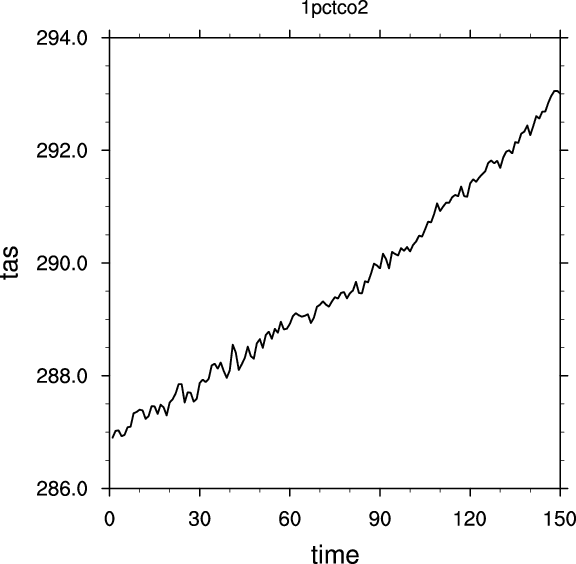

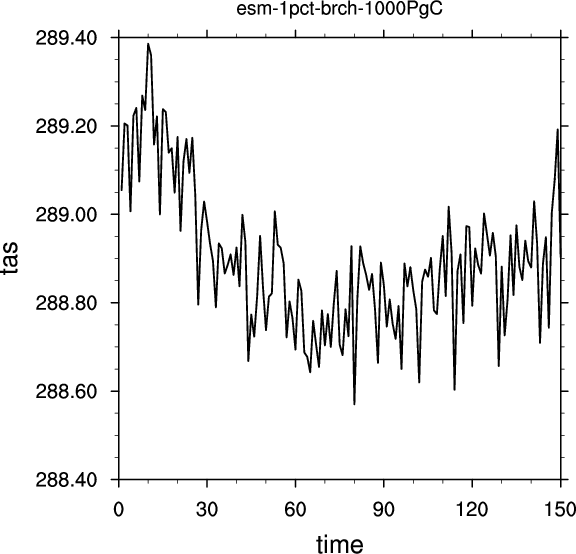

In [5]:
### calculate tas

for case_i in range(len(casenames)):
    case = casenames[case_i]
    var = "TREFHT"
    TREFHT = xr.open_mfdataset(datadirbase+case+'/*/proc/tseries/month_1/'+case+'*.'+var+'.*.nc')
    #
    tas = (smoothlib.monthly_to_annual_xarray(TREFHT['TREFHT']) * area_file['areacella']).sum(axis=1).sum(axis=1)/area_file['areacella'].sum()
    #
    np.savetxt('tas_cesm2_'+exp_names[case_i]+'_0001_0150.csv',np.column_stack([np.arange(len(tas), dtype=np.int)+1,tas.to_masked_array()]), delimiter=',')
    #
    map_funcs.xyplot(np.arange(len(tas))+1., tas.to_masked_array(), xtitle='time', ytitle='tas', showjupyter=True, title=exp_names[case_i])

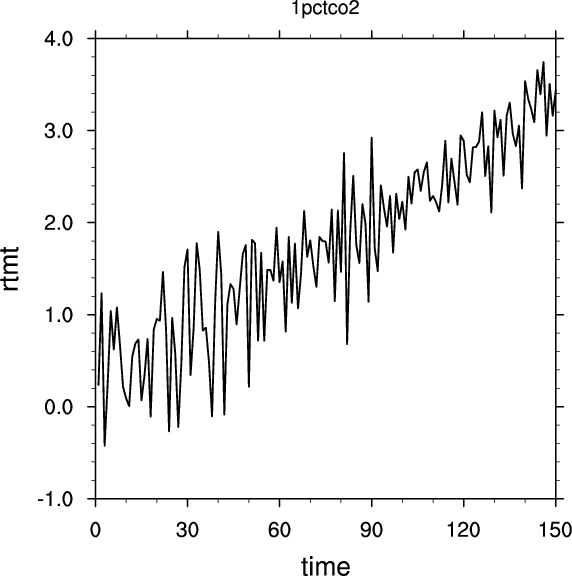

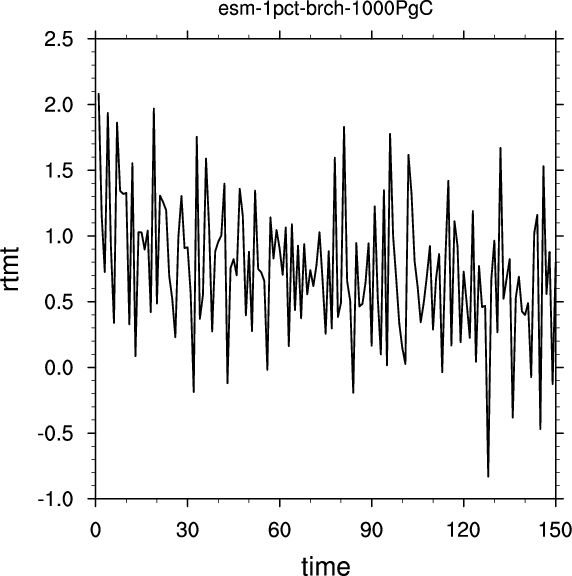

In [6]:
### calculate rtmt = FSNT - FLNT

for case_i in range(len(casenames)):
    case = casenames[case_i]
    var = "FSNT"
    FSNT = xr.open_mfdataset(datadirbase+case+'/*/proc/tseries/month_1/'+case+'*.'+var+'.*.nc')
    var = "FLNT"
    FLNT = xr.open_mfdataset(datadirbase+case+'/*/proc/tseries/month_1/'+case+'*.'+var+'.*.nc')
    #
    rtmt = (smoothlib.monthly_to_annual_xarray(FSNT['FSNT'] - FLNT['FLNT']) * area_file['areacella']).sum(axis=1).sum(axis=1)/area_file['areacella'].sum()
    #
    np.savetxt('rtmt_cesm2_'+exp_names[case_i]+'_0001_0150.csv',np.column_stack([np.arange(len(rtmt), dtype=np.int)+1,rtmt.to_masked_array()]), delimiter=',')
    #
    map_funcs.xyplot(np.arange(len(rtmt))+1., rtmt.to_masked_array(), xtitle='time', ytitle='rtmt', showjupyter=True, title=exp_names[case_i])

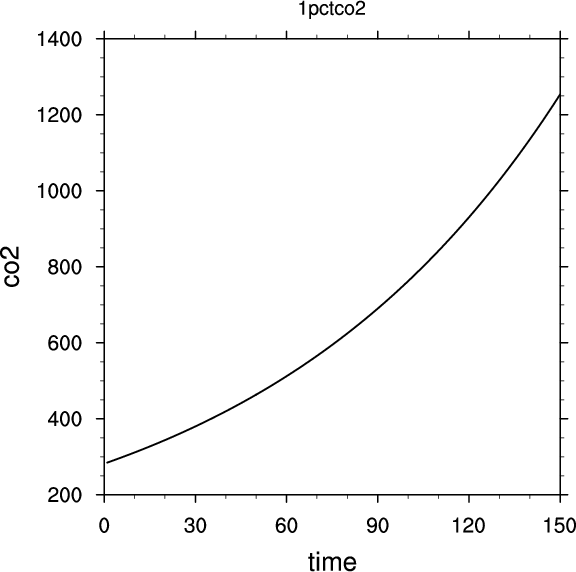

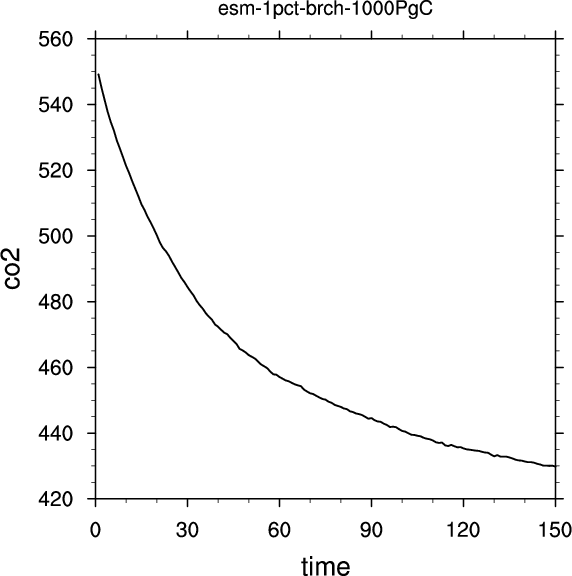

In [7]:
### calculate co2

for case_i in range(len(casenames)):
    case = casenames[case_i]
    if exp_names[case_i] != '1pctco2':
        var = "CO2"
        CO2 = xr.open_mfdataset(datadirbase+case+'/*/proc/tseries/month_1/'+case+'*.'+var+'.*.nc')
        #
        co2 = (smoothlib.monthly_to_annual_xarray(CO2['CO2'][:,31,:,:]*1e6*28.966/44.0) * area_file['areacella']).sum(axis=1).sum(axis=1)/area_file['areacella'].sum()
    else:   # in this case, because the 1pctco2 was run as 
        co2_1850 = 284.7  ## CESM used the CMIP5 rather than the CMIP6 value
        co2 = xr.DataArray(co2_1850 * 1.01 ** np.arange(150))
    #
    np.savetxt('co2_cesm2_'+exp_names[case_i]+'_0001_0150.csv',np.column_stack([np.arange(len(co2), dtype=np.int)+1,co2.to_masked_array()]), delimiter=',')
    #
    map_funcs.xyplot(np.arange(len(co2))+1., co2.to_masked_array(), xtitle='time', ytitle='co2', showjupyter=True, title=exp_names[case_i])

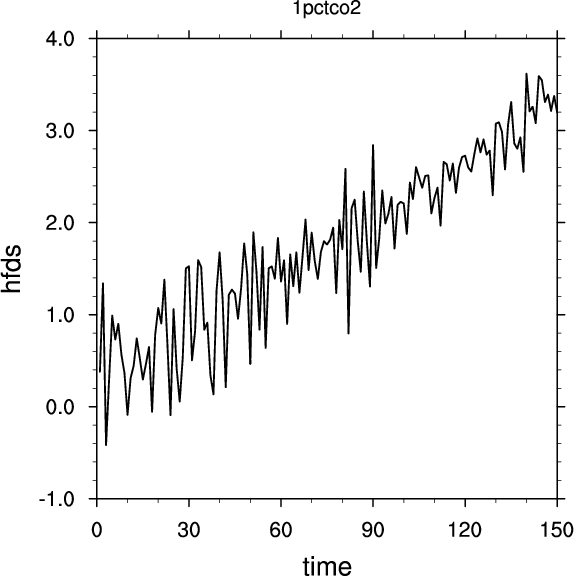

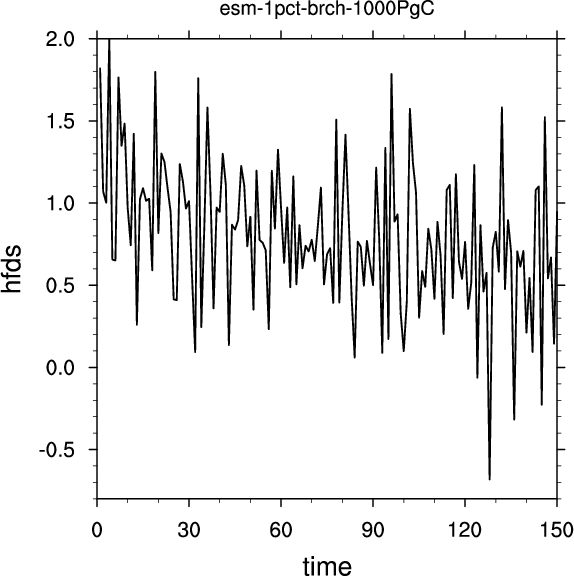

In [8]:
### calculate hfds = SHF+QFLUX

for case_i in range(len(casenames)):
    case = casenames[case_i]
    var = "SHF"
    SHF = xr.open_mfdataset(datadirbase+case+'/*/proc/tseries/month_1/'+case+'*.'+var+'.*.nc')
    var = "QFLUX"
    QFLUX = xr.open_mfdataset(datadirbase+case+'/*/proc/tseries/month_1/'+case+'*.'+var+'.*.nc')
    #
    hfds = (smoothlib.monthly_to_annual_xarray(SHF['SHF'] + QFLUX['QFLUX']) * area_file_ocn_gn['areacello']).sum(axis=1).sum(axis=1)/area_file_ocn_gn['areacello'].sum()
    #
    np.savetxt('hfds_cesm2_'+exp_names[case_i]+'_0001_0150.csv',np.column_stack([np.arange(len(hfds), dtype=np.int)+1,hfds.to_masked_array()]), delimiter=',')
    #
    map_funcs.xyplot(np.arange(len(hfds))+1., hfds.to_masked_array(), xtitle='time', ytitle='hfds', showjupyter=True, title=exp_names[case_i])

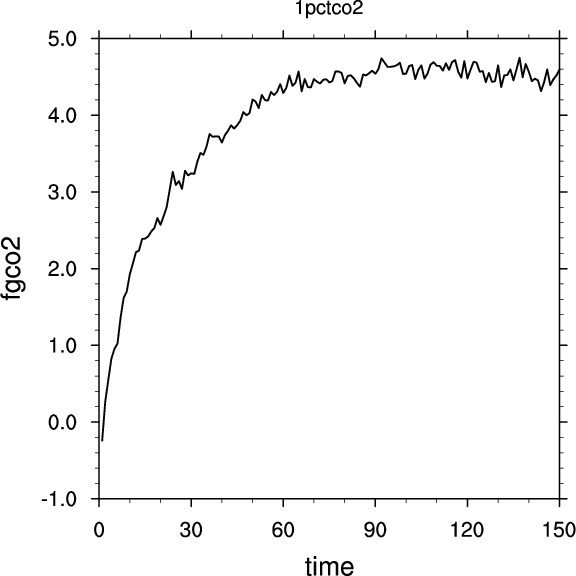

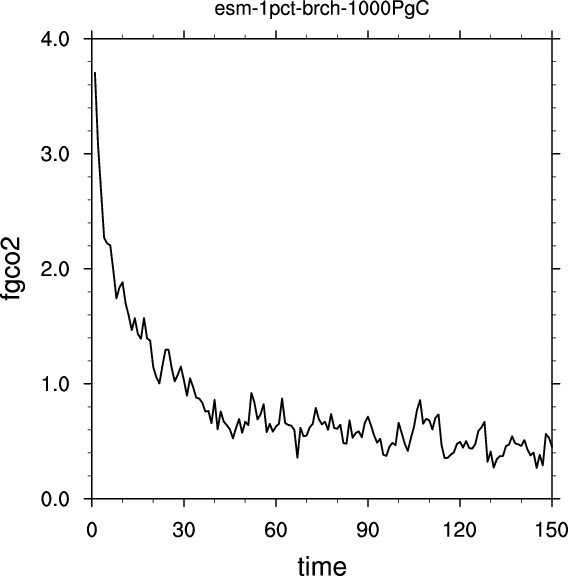

In [9]:
### calculate fgco2

for case_i in range(len(casenames)):
    case = casenames[case_i]
    var = "FG_CO2"
    FG_CO2 = xr.open_mfdataset(datadirbase+case+'/*/proc/tseries/month_1/'+case+'*.'+var+'.*.nc')
    #
    fgco2 = (smoothlib.monthly_to_annual_xarray(FG_CO2['FG_CO2']) * area_file_ocn_gn['areacello']).sum(axis=1).sum(axis=1) * 1e-15 * 86400. * .01 * .001 * 12. * 365.
    #
    np.savetxt('fgco2_cesm2_'+exp_names[case_i]+'_0001_0150.csv',np.column_stack([np.arange(len(fgco2), dtype=np.int)+1,fgco2.to_masked_array()]), delimiter=',')
    #
    map_funcs.xyplot(np.arange(len(fgco2))+1., fgco2.to_masked_array(), xtitle='time', ytitle='fgco2', showjupyter=True, title=exp_names[case_i])

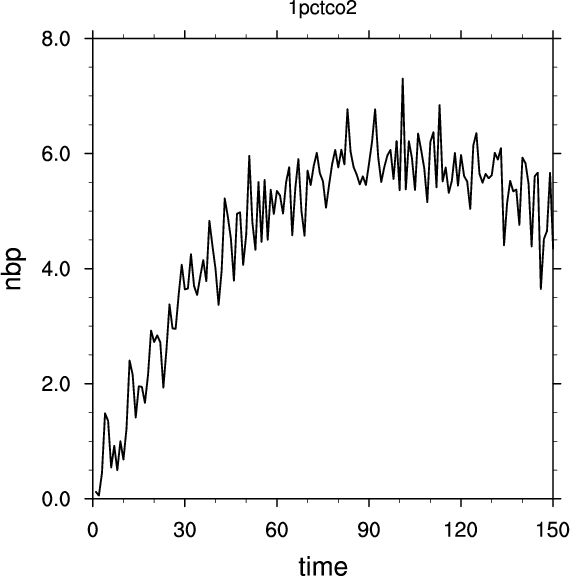

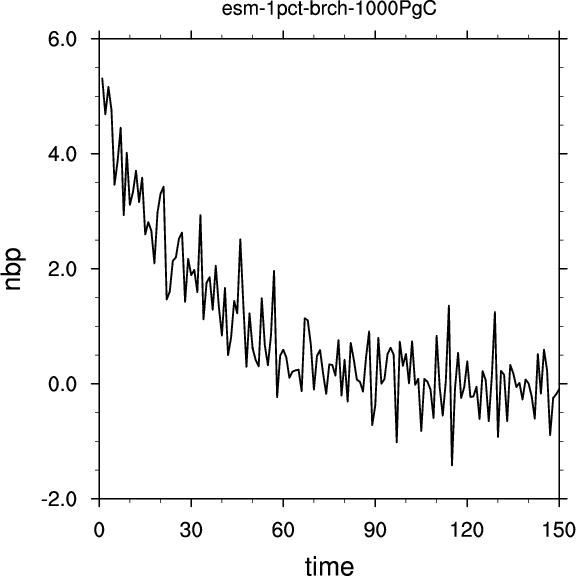

In [10]:
### calculate nbp

for case_i in range(len(casenames)):
    case = casenames[case_i]
    var = "NBP"
    NBP = xr.open_mfdataset(datadirbase+case+'/*/proc/tseries/month_1/'+case+'*.'+var+'.*.nc')
    #
    nbp = (smoothlib.monthly_to_annual_xarray(NBP['NBP']) * area_landonly).sum(axis=1).sum(axis=1) * 1e-15 * 86400. * 365.
    #
    np.savetxt('nbp_cesm2_'+exp_names[case_i]+'_0001_0150.csv',np.column_stack([np.arange(len(nbp), dtype=np.int)+1,nbp.to_masked_array()]), delimiter=',')
    #
    map_funcs.xyplot(np.arange(len(nbp))+1., nbp.to_masked_array(), xtitle='time', ytitle='nbp', showjupyter=True, title=exp_names[case_i])

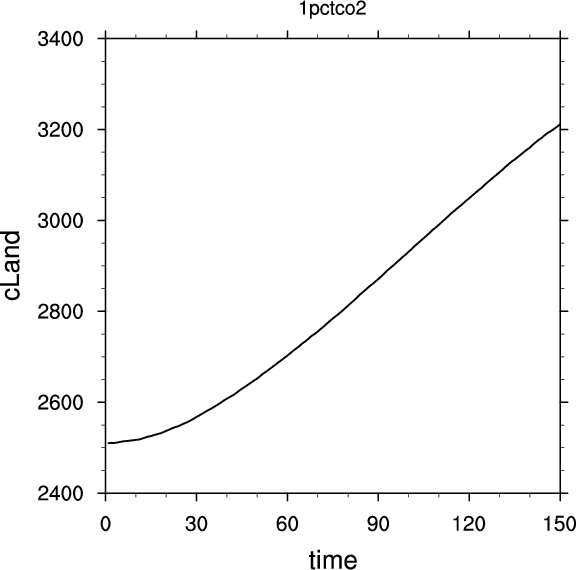

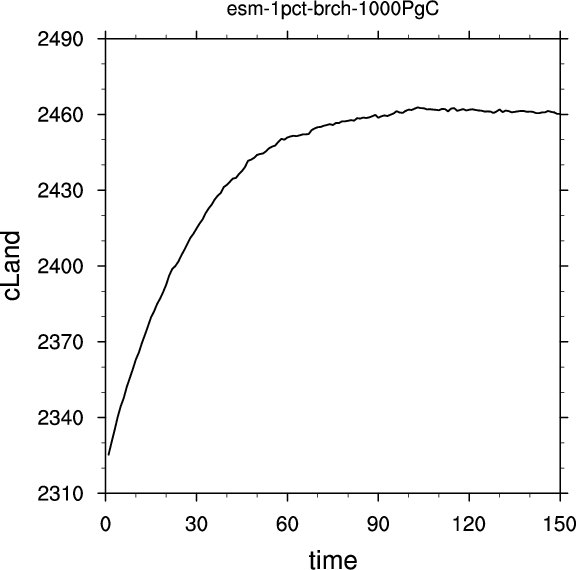

In [11]:
### calculate cLand

for case_i in range(len(casenames)):
    case = casenames[case_i]
    var = "TOTECOSYSC"
    TOTECOSYSC = xr.open_mfdataset(datadirbase+case+'/*/proc/tseries/month_1/'+case+'*.'+var+'.*.nc')
    #
    cLand = (smoothlib.monthly_to_annual_xarray(TOTECOSYSC['TOTECOSYSC']) * area_landonly).sum(axis=1).sum(axis=1) * 1e-15
    #
    np.savetxt('cLand_cesm2_'+exp_names[case_i]+'_0001_0150.csv',np.column_stack([np.arange(len(cLand), dtype=np.int)+1,cLand.to_masked_array()]), delimiter=',')
    #
    map_funcs.xyplot(np.arange(len(cLand))+1., cLand.to_masked_array(), xtitle='time', ytitle='cLand', showjupyter=True, title=exp_names[case_i])